# &#x1F310; &nbsp; Code Library, Style, and Links
Version in `PYTHON`:

&#x1F4D8; &nbsp; [kaggle_passnyc2.ipynb](https://github.com/OlgaBelitskaya/kaggle_notebooks/blob/master/kaggle_passnyc2.ipynb)

The previous notebook:

&#x1F4D8; &nbsp; [kaggle_passnyc_R.ipynb](https://github.com/OlgaBelitskaya/kaggle_notebooks/blob/master/kaggle_passnyc_R.ipynb)

Useful `LINKS`:

&#x1F4E1; &nbsp; [School Quality Reports. Educator Guide](http://schools.nyc.gov/NR/rdonlyres/967E0EE1-7E5D-4E47-BC21-573FEEE23AE2/0/201516EducatorGuideHS9252017.pdf)

&#x1F4E1; &nbsp; [New York City Department of Education](https://www.schools.nyc.gov)

&#x1F4E1; &nbsp; [NYC OpenData](https://opendata.cityofnewyork.us/)

&#x1F4E1; &nbsp; [ggplot2](https://ggplot2.tidyverse.org/)

&#x1F4E1; &nbsp; [R Tutorial](https://www.tutorialspoint.com/r/index.htm)

In [2]:
library(IRdisplay)
library(repr)
library(tidyverse)
library(formattable)
library(zoo)
library(grid)
library(gridExtra)
library(sf)
library(Rtsne)
library(corrplot)

#library(tensorflow)
#library(keras)
#library(imager)
#library(R6)
#library(colormap)
#library(purrr)
#library(DT)

In [1173]:
#keras_backend <- backend()

In [1174]:
display_html("<style> 
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: gainsboro;} 
a {color: #37c9e1; font-family: 'Roboto';} 
h1 {color: #37c9e1; font-family: 'Orbitron'; text-shadow: 5px 5px 5px #aaa;} 
h2, h3 {color: slategray; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #aaa;}
h4 {color: #818286; font-family: 'Roboto';}
span {text-shadow: 4px 4px 4px #aaa;}
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: #37c9e1;}      
div.output_stderr pre {background-color: gainsboro;}  
div.output_stderr {background-color: slategrey;}
</style>")

In [3]:
b <- "#3636ff"
r <- "#ff3636"
lr <- "#ff6f6f"
lb <- "#6f6fff"

## &#x1F310; &nbsp; Load and Preprocess the Data

In [4]:
school_explorer <- read.csv("2016 School Explorer.csv")
d5_shsat <- read.csv("D5 SHSAT Registrations and Testers.csv")

In [5]:
dim(school_explorer); dim(d5_shsat)
cat(colnames(school_explorer)[1:38],sep=", ")

[1] 1272  161

[1] 140   7

Adjusted.Grade, New., Other.Location.Code.in.LCGMS, School.Name, SED.Code, Location.Code, District, Latitude, Longitude, Address..Full., City, Zip, Grades, Grade.Low, Grade.High, Community.School., Economic.Need.Index, School.Income.Estimate, Percent.ELL, Percent.Asian, Percent.Black, Percent.Hispanic, Percent.Black...Hispanic, Percent.White, Student.Attendance.Rate, Percent.of.Students.Chronically.Absent, Rigorous.Instruction.., Rigorous.Instruction.Rating, Collaborative.Teachers.., Collaborative.Teachers.Rating, Supportive.Environment.., Supportive.Environment.Rating, Effective.School.Leadership.., Effective.School.Leadership.Rating, Strong.Family.Community.Ties.., Strong.Family.Community.Ties.Rating, Trust.., Trust.Rating

In [6]:
school_explorer <- school_explorer[,4:161]

school_explorer[school_explorer == "N/A"] <- NA

school_explorer$School.Name <- as.character(school_explorer$School.Name)
school_explorer$School.Name[c(428,1024,713,909)] <- 
c('P.S. 212 D12','P.S. 212 D30','P.S. 253 D21','P.S. 253 D27')

school_explorer$School.Income.Estimate <- as.character(school_explorer$School.Income.Estimate)
school_explorer$School.Income.Estimate <- sub("\\$","",school_explorer$School.Income.Estimate)
school_explorer$School.Income.Estimate <- sub(",","",school_explorer$School.Income.Estimate)
school_explorer$School.Income.Estimate <- as.numeric(school_explorer$School.Income.Estimate)
school_explorer$School.Income.Estimate <- na.approx(school_explorer$School.Income.Estimate)

percent_list <- c('Percent.ELL',
                  'Percent.Asian','Percent.Black','Percent.Hispanic',
                  'Percent.Black...Hispanic','Percent.White',
                  'Student.Attendance.Rate',
                  'Percent.of.Students.Chronically.Absent',
                  'Rigorous.Instruction..','Collaborative.Teachers..',
                  'Supportive.Environment..','Effective.School.Leadership..',
                  'Strong.Family.Community.Ties..','Trust..')
target_list <- c("Average.ELA.Proficiency","Average.Math.Proficiency")
economic_list <- c("Economic.Need.Index","School.Income.Estimate")
rating_list <- c('Rigorous.Instruction.Rating','Collaborative.Teachers.Rating',
                 'Supportive.Environment.Rating','Effective.School.Leadership.Rating',
                 'Strong.Family.Community.Ties.Rating','Trust.Rating',
                 'Student.Achievement.Rating')

nastr2num <- function(x){ x <- as.numeric(sub("%","",x))}

for (el in c(percent_list,target_list,"Economic.Need.Index")) {
    school_explorer[el] <- sapply(school_explorer[el],nastr2num)
    school_explorer[el] <- na.approx(school_explorer[el])
}

for (el in rating_list) {
    vtable <- data.frame(table(school_explorer[el]))
    mvalue <- as.character(vtable$Var1[vtable$Freq == max(vtable$Freq)])
    school_explorer[el][is.na(school_explorer[el])] <- mvalue
    school_explorer[,el] <- factor(school_explorer[,el])
}

In [7]:
sum(is.na(school_explorer))

[1] 0

In [8]:
districts <- data.frame(
    aggregate(. ~ District, 
              school_explorer[c('District',target_list,economic_list)], 
              mean))
dim(districts)

[1] 32  5

In [9]:
geo_districts <- sf::st_read("nysd.shp")
geo_districts$centroid <- st_centroid(geo_districts$geometry)
geo_districts <- st_transform(geo_districts,crs=4326)
geo_districts$centroid <- st_transform(geo_districts$centroid,crs=4326)
geo_districts <- data.frame(geo_districts)
geo_districts <- geo_districts[order(geo_districts$SchoolDist),]
rownames(geo_districts) <- c(1:33)

Reading layer `nysd' from data source `/Users/olgabelitskaya/kaggle_notebooks/nysd.shp' using driver `ESRI Shapefile'
Simple feature collection with 33 features and 3 fields
geometry type:  MULTIPOLYGON
dimension:      XY
bbox:           xmin: 913175.1 ymin: 120121.9 xmax: 1067383 ymax: 272844.3
epsg (SRID):    NA
proj4string:    +proj=lcc +lat_1=40.66666666666666 +lat_2=41.03333333333333 +lat_0=40.16666666666666 +lon_0=-74 +x_0=300000 +y_0=0 +datum=NAD83 +units=us-ft +no_defs


In [10]:
coords <- do.call(rbind, st_geometry(geo_districts$centroid)) %>% 
              as_tibble() %>% 
              setNames(c("lon","lat"))
geo_districts[c('lon','lat')] <- coords

In [11]:
head(geo_districts,11)

SchoolDist,Shape_Leng,Shape_Area,geometry,centroid,lon,lat
1,28641.276,35160748,MULTIPOLYGON (((-73.97177 4...,POINT (-73.98273 40.72144),-73.98273,40.72144
2,214498.703,280467718,MULTIPOLYGON (((-74.04388 4...,POINT (-73.98643 40.74434),-73.98643,40.74434
3,52072.051,113488883,MULTIPOLYGON (((-73.95672 4...,POINT (-73.96902 40.789),-73.96902,40.78900
4,52061.828,52620428,MULTIPOLYGON (((-73.92134 4...,POINT (-73.93381 40.79263),-73.93381,40.79263
5,44469.588,52519774,MULTIPOLYGON (((-73.93516 4...,POINT (-73.94444 40.81471),-73.94444,40.81471
6,70447.849,96341704,MULTIPOLYGON (((-73.92641 4...,POINT (-73.93495 40.84956),-73.93495,40.84956
7,65294.452,92262468,MULTIPOLYGON (((-73.89681 4...,POINT (-73.91105 40.80878),-73.91105,40.80878
8,223080.143,258826603,MULTIPOLYGON (((-73.83979 4...,POINT (-73.85011 40.8224),-73.85011,40.82240
9,46648.959,83415392,MULTIPOLYGON (((-73.9213 40...,POINT (-73.91352 40.83897),-73.91352,40.83897
10,94957.571,282541462,MULTIPOLYGON (((-73.8679 40...,POINT (-73.89331 40.8796),-73.89331,40.87960


School Districts

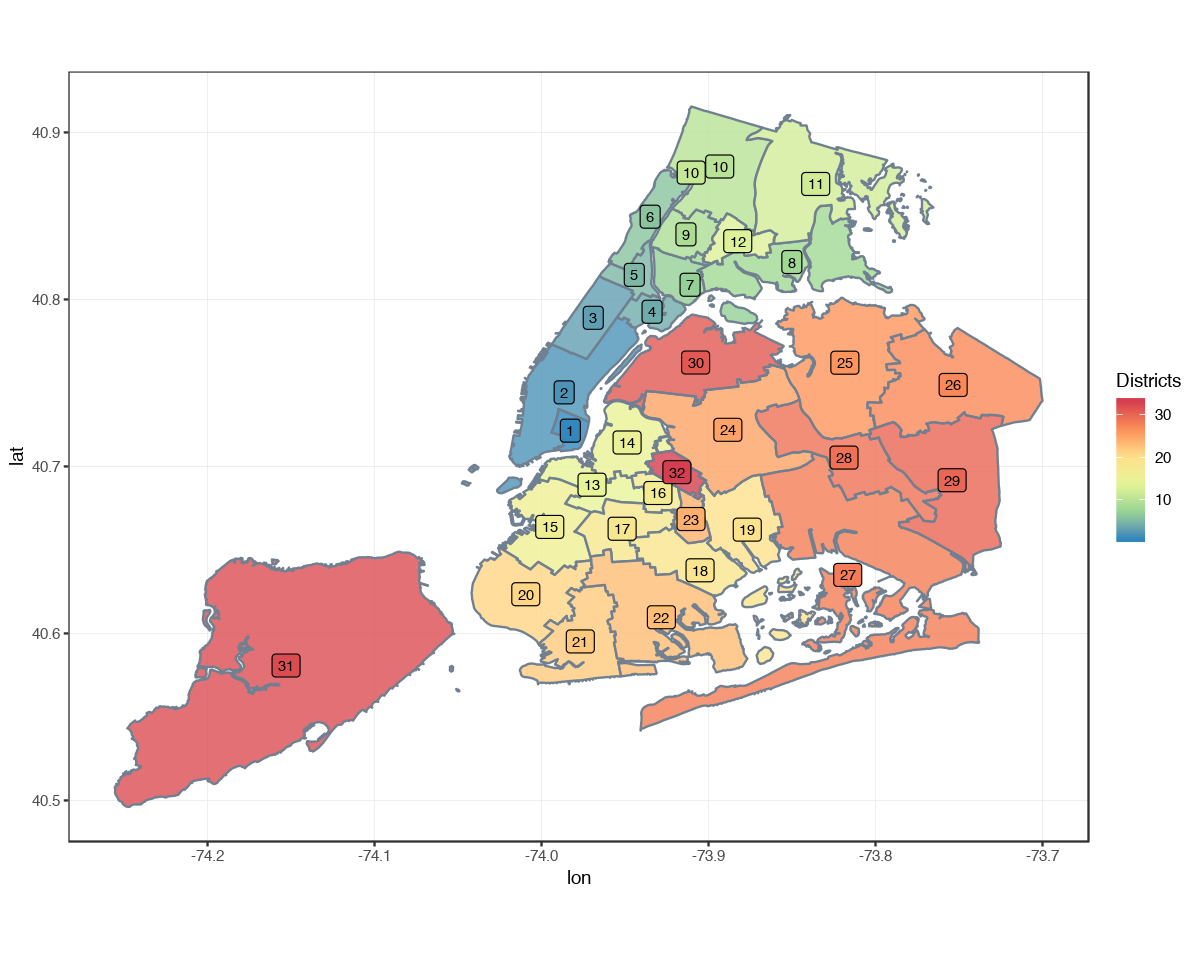

In [12]:
options(repr.plot.width=10,repr.plot.height=8)
display_html('<p style="color:#3636ff; font-family:Roboto; font-size:150%; text-shadow:5px 5px 5px #aaa;">
School Districts</p>')
ggplot(geo_districts,aes(fill=c(1:33))) + 
    geom_sf(data=geo_districts,size=0.5,
            color="slategray",alpha=0.8) + 
    geom_label(aes(x=lon,y=lat,label=SchoolDist),size=3) +
    scale_fill_distiller(name="Districts",palette = "Spectral") +
    theme_bw()

## &#x1F310; &nbsp; Classification of Variables

In [13]:
cat('Numeric Variables')
numeric_list <- unlist(lapply(school_explorer,is.numeric))
numeric_list <- colnames(school_explorer[numeric_list])
numeric_list[1:25]

Numeric Variables

[1] "SED.Code"                              
 [2] "District"                              
 [3] "Latitude"                              
 [4] "Longitude"                             
 [5] "Zip"                                   
 [6] "Economic.Need.Index"                   
 [7] "School.Income.Estimate"                
 [8] "Percent.ELL"                           
 [9] "Percent.Asian"                         
[10] "Percent.Black"                         
[11] "Percent.Hispanic"                      
[12] "Percent.Black...Hispanic"              
[13] "Percent.White"                         
[14] "Student.Attendance.Rate"               
[15] "Percent.of.Students.Chronically.Absent"
[16] "Rigorous.Instruction.."                
[17] "Collaborative.Teachers.."              
[18] "Supportive.Environment.."              
[19] "Effective.School.Leadership.."         
[20] "Strong.Family.Community.Ties.."        
[21] "Trust.."                               
[22] "Average.ELA.Proficiency"               
[23] "Average.Math.Proficiency"              
[24] "Grade.3.ELA...All.Students.Tested"     
[25] "Grade.3.ELA.4s...All.Students"

In [14]:
summary(school_explorer[numeric_list][,1:9])

    SED.Code            District        Latitude       Longitude     
 Min.   :3.075e+11   Min.   : 1.00   Min.   :40.51   Min.   :-74.24  
 1st Qu.:3.209e+11   1st Qu.: 9.00   1st Qu.:40.67   1st Qu.:-73.96  
 Median :3.315e+11   Median :15.00   Median :40.72   Median :-73.92  
 Mean   :3.287e+11   Mean   :16.14   Mean   :40.73   Mean   :-73.92  
 3rd Qu.:3.424e+11   3rd Qu.:24.00   3rd Qu.:40.82   3rd Qu.:-73.88  
 Max.   :3.531e+11   Max.   :32.00   Max.   :40.90   Max.   :-73.71  
      Zip        Economic.Need.Index.Economic.Need.Index School.Income.Estimate
 Min.   :10001   Min.   :0.0490000                       Min.   : 16902        
 1st Qu.:10452   1st Qu.:0.5510000                       1st Qu.: 33381        
 Median :11203   Median :0.7282500                       Median : 43572        
 Mean   :10816   Mean   :0.6719953                       Mean   : 48014        
 3rd Qu.:11232   3rd Qu.:0.8400000                       3rd Qu.: 57783        
 Max.   :11694   Max.   :0.957

In [15]:
cat('Categorical Variables')
category_list <- !unlist(lapply(school_explorer,is.numeric))
category_list <- colnames(school_explorer[category_list])
category_list

Categorical Variables

[1] "School.Name"                         "Location.Code"                      
 [3] "Address..Full."                      "City"                               
 [5] "Grades"                              "Grade.Low"                          
 [7] "Grade.High"                          "Community.School."                  
 [9] "Rigorous.Instruction.Rating"         "Collaborative.Teachers.Rating"      
[11] "Supportive.Environment.Rating"       "Effective.School.Leadership.Rating" 
[13] "Strong.Family.Community.Ties.Rating" "Trust.Rating"                       
[15] "Student.Achievement.Rating"

In [16]:
summary(school_explorer[category_list][,1:9])

 School.Name        Location.Code                            Address..Full.
 Length:1272        01M015 :   1   100 W 77TH ST NEW YORK, NY 10024 :   3  
 Class :character   01M019 :   1   1000 TELLER AVE BRONX, NY 10456  :   3  
 Mode  :character   01M020 :   1   108-35 167TH ST JAMAICA, NY 11433:   3  
                    01M034 :   1   125 E 181ST ST BRONX, NY 10453   :   3  
                    01M063 :   1   154 W 93RD ST NEW YORK, NY 10025 :   3  
                    01M064 :   1   1827 ARCHER ST BRONX, NY 10460   :   3  
                    (Other):1266   (Other)                          :1254  
            City                               Grades      Grade.Low  
 BROOKLYN     :411   PK,0K,01,02,03,04,05         :400   PK     :525  
 BRONX        :297   06,07,08                     :264   06     :355  
 NEW YORK     :232   0K,01,02,03,04,05            :207   0K     :349  
 STATEN ISLAND: 60   0K,01,02,03,04,05,06,07,08   : 89   05     : 23  
 JAMAICA      : 32   PK,0K,01,02,03,0

Of course, the variables `SED Code`, `District`, `Zip` are categorical. 

Just categories are denoted by numeric values.

Let's convert string values of other categorical features into numeric.

In [17]:
numeric_list <- numeric_list[c(6:21,24:143)]
numeric_list[1:20]

[1] "Economic.Need.Index"                              
 [2] "School.Income.Estimate"                           
 [3] "Percent.ELL"                                      
 [4] "Percent.Asian"                                    
 [5] "Percent.Black"                                    
 [6] "Percent.Hispanic"                                 
 [7] "Percent.Black...Hispanic"                         
 [8] "Percent.White"                                    
 [9] "Student.Attendance.Rate"                          
[10] "Percent.of.Students.Chronically.Absent"           
[11] "Rigorous.Instruction.."                           
[12] "Collaborative.Teachers.."                         
[13] "Supportive.Environment.."                         
[14] "Effective.School.Leadership.."                    
[15] "Strong.Family.Community.Ties.."                   
[16] "Trust.."                                          
[17] "Grade.3.ELA...All.Students.Tested"                
[18] "Grade.3.ELA.4s...All.Students"                    
[19] "Grade.3.ELA.4s...American.Indian.or.Alaska.Native"
[20] "Grade.3.ELA.4s...Black.or.African.American"

In [18]:
display_html('<p style="color:#3636ff; font-family:Roboto; font-size:150%; text-shadow:5px 5px 5px #aaa;">
Unique Values of Categorical Variables</p>')
cat('District')
unique(school_explorer$District)
cat('City')
unique(school_explorer$City)
cat('Grades')
unique(school_explorer$Grades)
cat('Community School')
unique(school_explorer$Community.School.)
cat('Trust Rating')
unique(school_explorer$Trust.Rating)

Unique Values of Categorical Variables

District

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 23 18 19 20 21 22 24 25
[26] 26 27 28 29 30 31 32

City

[1] NEW YORK            ROOSEVELT ISLAND    BRONX              
 [4] BROOKLYN            ELMHURST            WOODSIDE           
 [7] CORONA              MIDDLE VILLAGE      MASPETH            
[10] RIDGEWOOD           GLENDALE            LONG ISLAND CITY   
[13] FLUSHING            COLLEGE POINT       WHITESTONE         
[16] BAYSIDE             QUEENS VILLAGE      LITTLE NECK        
[19] DOUGLASTON          FLORAL PARK         BELLEROSE          
[22] JAMAICA             ARVERNE             FAR ROCKAWAY       
[25] SOUTH OZONE PARK    BROAD CHANNEL       RICHMOND HILL      
[28] WOODHAVEN           SOUTH RICHMOND HILL OZONE PARK         
[31] ROCKAWAY PARK       HOWARD BEACH        ROCKAWAY BEACH     
[34] KEW GARDENS         FOREST HILLS        REGO PARK          
[37] SPRINGFIELD GARDENS HOLLIS              SAINT ALBANS       
[40] ROSEDALE            CAMBRIA HEIGHTS     JACKSON HEIGHTS    
[43] ASTORIA             EAST ELMHURST       STATEN ISLAND      
45 Levels: ARVERNE ASTORIA BAYSIDE BELLEROSE BROAD CHANNEL BRONX ... WOODSIDE

Grades

[1] PK,0K,01,02,03,04,05                     
 [2] PK,0K,01,02,03,04,05,06,07,08            
 [3] 06,07,08,09,10,11,12                     
 [4] 06,07,08                                 
 [5] 0K,01,02,03,04,05,06,07,08,09,10,11,12   
 [6] 0K,01,02,03,04,05                        
 [7] 0K,01,02,03,04,05,06,07,08               
 [8] 04,05,06,07,08                           
 [9] 03,04,05                                 
[10] 05,06,07,08                              
[11] 06,07,08,SE                              
[12] 0K,01,02,03,04,05,06,07,08,SE            
[13] PK,0K,01,02,03,04,05,06                  
[14] 07,08,09,10,11,12                        
[15] 0K,01,02                                 
[16] PK,0K,01,02,03,04,05,06,07,08,09,10,11,12
[17] PK,0K,01,02,03,04,05,SE                  
[18] 06,07,08,09,10,11,12,SE                  
[19] PK,0K,01,02,03                           
[20] 04,05                                    
[21] 0K,01,02,03,04                           
[22] 0K,01,02,03,04,05,06                     
[23] 0K,01,02,03                              
[24] 09,10,11,12                              
[25] PK,0K,01,03,04,05                        
[26] PK,0K,01,02                              
[27] PK,0K,01,02,03,04                        
[28] 02,03,04,05                              
[29] PK,0K,01,02,03,04,05,07,08               
[30] PK,0K,01,02,03,04,05,06,07,08,SE         
[31] 01,02,03,04,05,06,SE                     
[32] 0K,01,02,03,04,05,SE                     
[33] 0K                                       
[34] 03,04,05,06                              
[35] 06,07,08,09                              
[36] 0K,01,03,04,05,06,07,08                  
[37] 05,06,07,08,09,10,11,12                  
[38] 06,07,08,09,10                           
[39] 01,05,06,07,08,K                         
[40] 01,02,03,04,05,06,07,08                  
[41] 0K,01,02,03,04,05,06,07                  
41 Levels: 01,02,03,04,05,06,07,08 01,02,03,04,05,06,SE ... PK,0K,01,03,04,05

Community School

[1] Yes No 
Levels: No Yes

Trust Rating

[1] Exceeding Target   Meeting Target     Not Meeting Target Approaching Target
4 Levels: Approaching Target Exceeding Target ... Not Meeting Target

In [19]:
category_list <- c('District','City','Grades','Community.School.',rating_list)
fac2num <- function(x) {as.numeric(as.factor(x))}
school_explorer[,category_list] <- lapply(school_explorer[,category_list], fac2num)

In [20]:
display_html('<p style="color:#3636ff; font-family:Roboto; font-size:150%; text-shadow:5px 5px 5px #aaa;">
Unique Values of Categorical Variables after Transformation</p>')
cat('District')
unique(school_explorer$District)
cat('City')
unique(school_explorer$City)
cat('Grades')
unique(school_explorer$Grades)
cat('Community School')
unique(school_explorer$Community.School.)
cat('Trust Rating')
unique(school_explorer$Trust.Rating)

Unique Values of Categorical Variables after Transformation

District

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 23 18 19 20 21 22 24 25
[26] 26 27 28 29 30 31 32

City

[1] 28 36  6  7 13 45 10 27 26 33 18 25 16  9 43  3 30 24 11 15  4 22  1 14 39
[26]  5 32 44 40 29 35 20 34 23 17 31 41 19 38 37  8 21  2 12 42

Grades

[1] 34 36 14 11 27 23 26  8  5  9 16 28 35 17 20 37 40 15 32  7 22 24 21 18 41
[26] 31 33  4 39 38  2 29 19  6 12 30 10 13  3  1 25

Community School

[1] 2 1

Trust Rating

[1] 2 3 4 1

## &#x1F310; &nbsp; Clustering

In [123]:
n <- 10
#algorithm="Hartigan-Wong",
clusters <- kmeans(school_explorer[,c(target_list,economic_list)],
                   n,iter.max=200)
school_explorer['Education.Clusters'] <- as.factor(clusters$cluster)

In [124]:
# By education results and economic indicators
str(clusters)

List of 9
 $ cluster     : int [1:1272] 3 9 2 3 4 2 2 3 1 1 ...
 $ centers     : num [1:10, 1:4] 2.4 2.45 2.34 2.54 2.29 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:10] "1" "2" "3" "4" ...
  .. ..$ : chr [1:4] "Average.ELA.Proficiency" "Average.Math.Proficiency" "Economic.Need.Index" "School.Income.Estimate"
 $ totss       : num 5.61e+11
 $ withinss    : num [1:10] 5.30e+08 8.36e+08 3.55e+08 1.20e+09 5.44e+08 ...
 $ tot.withinss: num 1.38e+10
 $ betweenss   : num 5.47e+11
 $ size        : int [1:10] 182 211 140 195 152 79 112 39 152 10
 $ iter        : int 3
 $ ifault      : int 0
 - attr(*, "class")= chr "kmeans"


Let's arrange these clusters in accordance with educational achievements.

In [125]:
ed_clusters <- data.frame(
    aggregate(. ~ Education.Clusters, 
              school_explorer[c('Education.Clusters',target_list,economic_list)], 
              mean))
ed_clusters <- ed_clusters[order(ed_clusters$Average.Math.Proficiency),]
rownames(ed_clusters) <- c(1:10)
ed_clusters

Education.Clusters,Average.ELA.Proficiency,Average.Math.Proficiency,Economic.Need.Index,School.Income.Estimate
5,2.290329,2.375713,0.8769594,24504.72
3,2.338417,2.426238,0.8254562,29210.24
1,2.399478,2.526181,0.7991525,35322.88
2,2.454055,2.601378,0.7334254,41575.35
4,2.540643,2.691647,0.6651400,48649.13
9,2.630164,2.779737,0.5678980,58268.41
7,2.782217,2.934141,0.4432937,68768.23
6,2.899019,3.095728,0.3500266,82183.09
8,3.154103,3.353846,0.2729231,104011.18
10,3.315000,3.449000,0.1750000,146384.55


In [126]:
c(ed_clusters$Education.Clusters)

[1]  5  3  1  2  4  9  7  6  8 10

In [127]:
mapping <- setNames(c("01", "02", "03","04","05","06", "07", "08","09","10"),
                    c(ed_clusters$Education.Clusters))
                    
school_explorer$Education.Clusters <- mapping[unlist(school_explorer$Education.Clusters)]
ed_clusters$Education.Clusters <- c("01", "02", "03","04","05","06", "07", "08","09","10")
ed_clusters

Education.Clusters,Average.ELA.Proficiency,Average.Math.Proficiency,Economic.Need.Index,School.Income.Estimate
01,2.290329,2.375713,0.8769594,24504.72
02,2.338417,2.426238,0.8254562,29210.24
03,2.399478,2.526181,0.7991525,35322.88
04,2.454055,2.601378,0.7334254,41575.35
05,2.540643,2.691647,0.6651400,48649.13
06,2.630164,2.779737,0.5678980,58268.41
07,2.782217,2.934141,0.4432937,68768.23
08,2.899019,3.095728,0.3500266,82183.09
09,3.154103,3.353846,0.2729231,104011.18
10,3.315000,3.449000,0.1750000,146384.55


The location of the results with good quality by districts and cluster types of schools can be assessed using visualization.

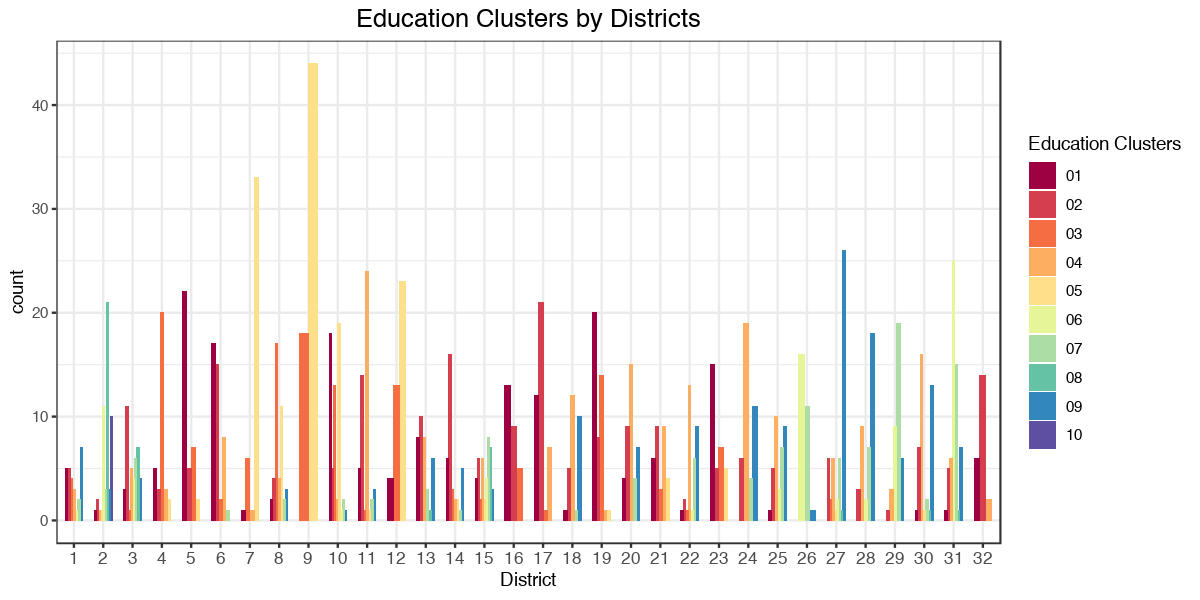

In [128]:
options(repr.plot.width=10,repr.plot.height=5)
p1 <- ggplot(school_explorer,aes(x=factor(District),fill=Education.Clusters)) +
          geom_bar(position="dodge",width=0.6) + theme_bw() +
          xlab("District") + ggtitle('Education Clusters by Districts') +
          scale_fill_brewer(name="Education Clusters",palette="Spectral") +
          theme(plot.title=element_text(size=15,hjust=0.5),
                axis.text.x=element_text(size=10,angle=0))
p1

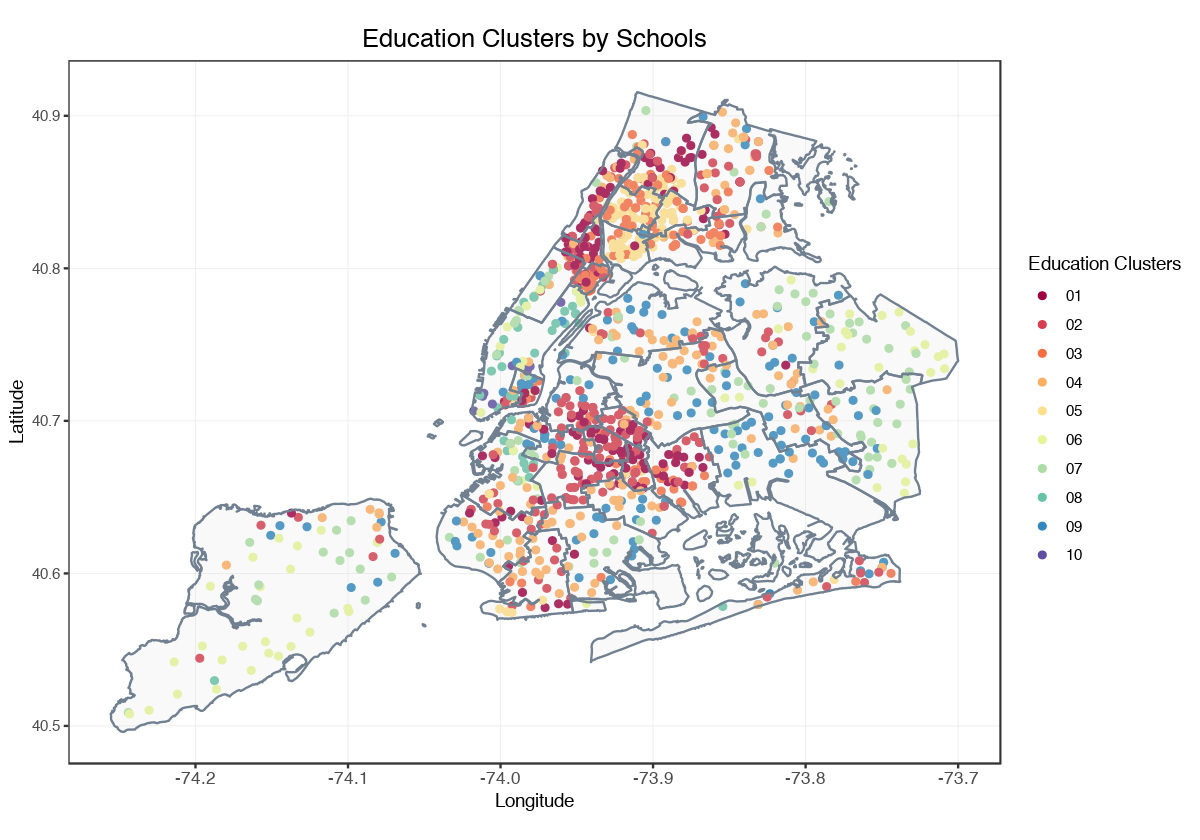

In [129]:
options(repr.plot.width=10,repr.plot.height=7)
p2 <- ggplot(school_explorer) +
          geom_point(aes(x=Longitude,y=Latitude,color=Education.Clusters)) + 
          scale_color_brewer(name="Education Clusters",palette="Spectral") +
          geom_sf(data=geo_districts,size=0.5,color="slategray",alpha=0.2) +
          theme_bw() + ggtitle('Education Clusters by Schools') +
          theme(plot.title=element_text(size=15,hjust=0.5),
                axis.text.x=element_text(size=10,angle=0))
p2

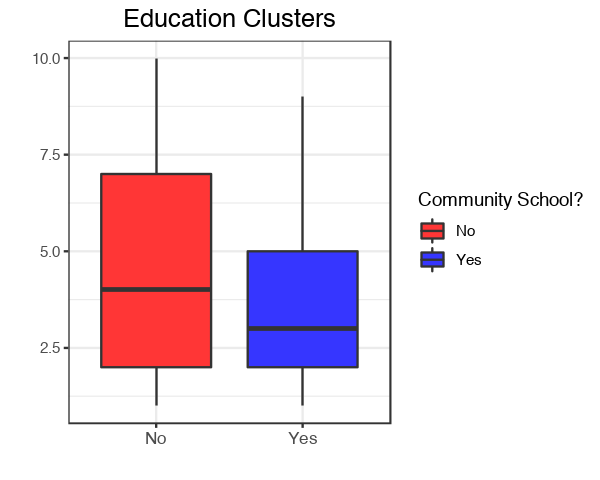

In [130]:
options(repr.plot.width=5,repr.plot.height=4)
plot_variable1 <- function(v) {
    ggplot(school_explorer,
           aes(x=factor(Community.School.),
               fill=factor(Community.School.))) +
    geom_boxplot(aes(y=c(factor(school_explorer[,v])))) +
    ggtitle(gsub("\\."," ",v)) +
    theme_bw() + xlab("") + ylab("") +
    scale_fill_manual(name="Community School?",
                      values=c(r,b),labels=c("No", "Yes")) +
    scale_x_discrete(labels=c("No", "Yes")) +
    theme(plot.title=element_text(size=15,hjust=0.5),
          axis.text.x=element_text(size=10,angle=0))
}

plot_variable1('Education.Clusters')

In [138]:
n <- 10
clusters <- kmeans(school_explorer[,c(target_list,percent_list)],
                   n,iter.max=300)
school_explorer['Education.Clusters'] <- as.factor(clusters$cluster)

In [139]:
# By education results, the social and demographic situation
str(clusters)

List of 9
 $ cluster     : int [1:1272] 2 2 5 2 2 2 5 5 3 3 ...
 $ centers     : num [1:10, 1:16] 3.12 2.32 2.33 2.32 2.61 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:10] "1" "2" "3" "4" ...
  .. ..$ : chr [1:16] "Average.ELA.Proficiency" "Average.Math.Proficiency" "Percent.ELL" "Percent.Asian" ...
 $ totss       : num 4892828
 $ withinss    : num [1:10] 40527 169937 106617 239204 104690 ...
 $ tot.withinss: num 979920
 $ betweenss   : num 3912908
 $ size        : int [1:10] 88 260 157 194 118 198 10 59 100 88
 $ iter        : int 3
 $ ifault      : int 0
 - attr(*, "class")= chr "kmeans"


In [140]:
ed_clusters <- data.frame(
    aggregate(. ~ Education.Clusters, 
              school_explorer[c('Education.Clusters',target_list,economic_list)], 
              mean))
ed_clusters <- ed_clusters[order(ed_clusters$Average.Math.Proficiency),]
rownames(ed_clusters) <- c(1:10)
ed_clusters

Education.Clusters,Average.ELA.Proficiency,Average.Math.Proficiency,Economic.Need.Index,School.Income.Estimate
4,2.323552,2.372204,0.7699096,41304.01
2,2.316316,2.399620,0.8399097,32048.77
3,2.333248,2.471306,0.8221911,37999.62
6,2.421960,2.494924,0.6798207,46984.17
5,2.610858,2.767320,0.6261686,51878.95
9,2.829570,2.997950,0.4555000,63237.31
10,2.936165,3.203097,0.4602682,62974.73
8,2.835169,3.234492,0.5870847,55242.81
1,3.121648,3.319545,0.2469091,88805.51
7,3.174000,3.804000,0.7043000,39758.14


In [141]:
mapping <- setNames(c("01", "02", "03","04","05","06", "07", "08","09","10"),
                    c(ed_clusters$Education.Clusters))
                    
school_explorer$Education.Clusters <- mapping[unlist(school_explorer$Education.Clusters)]
ed_clusters$Education.Clusters <- c("01", "02", "03","04","05","06", "07", "08","09","10")
ed_clusters

Education.Clusters,Average.ELA.Proficiency,Average.Math.Proficiency,Economic.Need.Index,School.Income.Estimate
01,2.323552,2.372204,0.7699096,41304.01
02,2.316316,2.399620,0.8399097,32048.77
03,2.333248,2.471306,0.8221911,37999.62
04,2.421960,2.494924,0.6798207,46984.17
05,2.610858,2.767320,0.6261686,51878.95
06,2.829570,2.997950,0.4555000,63237.31
07,2.936165,3.203097,0.4602682,62974.73
08,2.835169,3.234492,0.5870847,55242.81
09,3.121648,3.319545,0.2469091,88805.51
10,3.174000,3.804000,0.7043000,39758.14


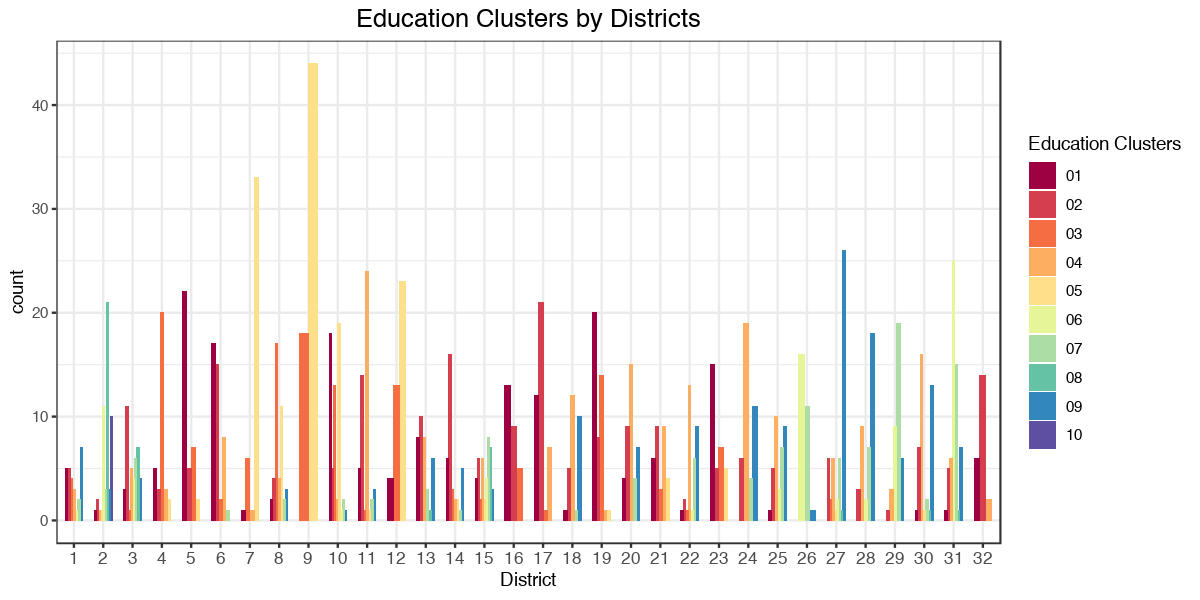

In [142]:
options(repr.plot.width=10,repr.plot.height=5)
p1

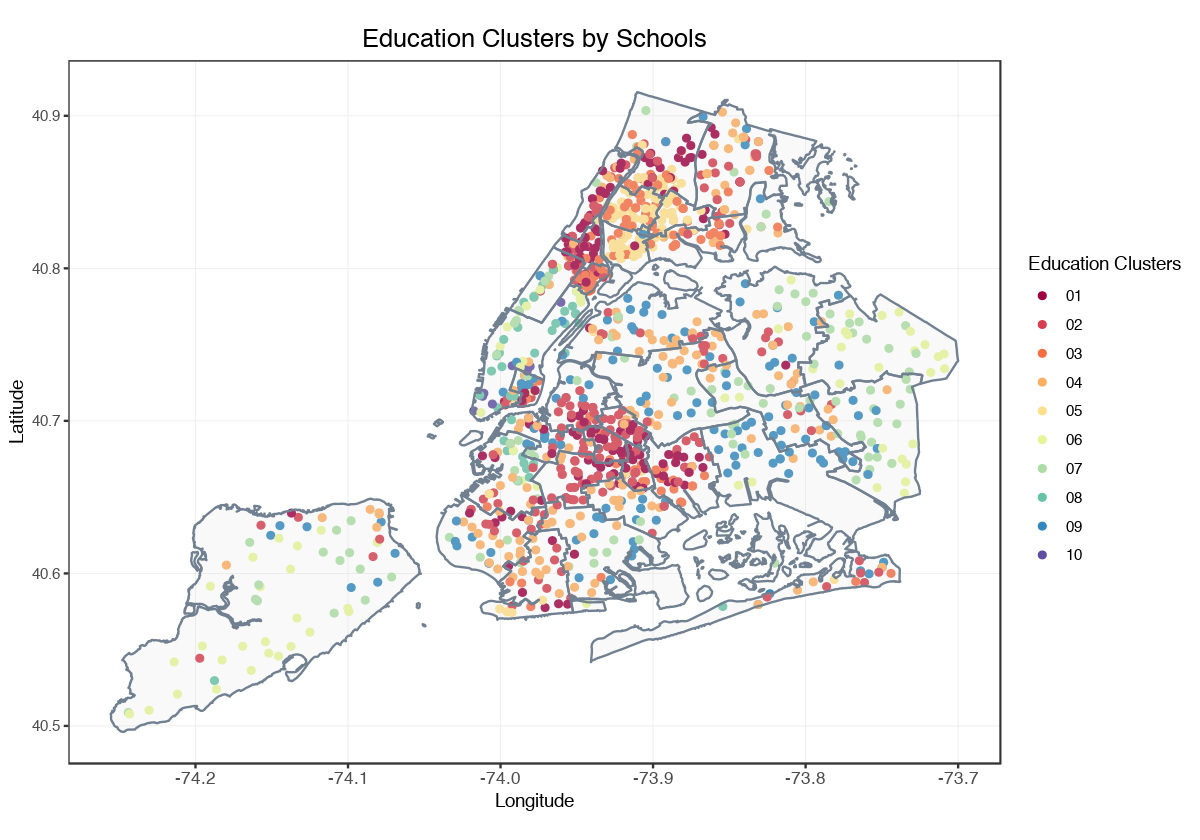

In [143]:
options(repr.plot.width=10,repr.plot.height=7)
p2

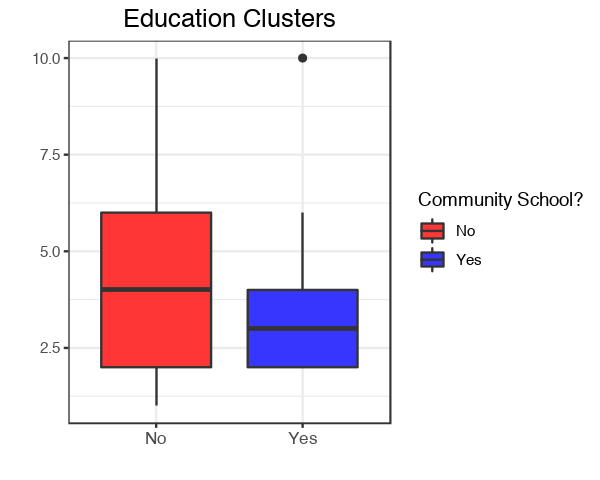

In [144]:
options(repr.plot.width=5,repr.plot.height=4)
plot_variable1('Education.Clusters')

The distribution by clusters has certain differences for two cases, but the problem regions are clearly the same.

## &#x1F310; &nbsp; Manifold Learning

Let's divide schools into educational clusters using numeric and categorical variables.

In [145]:
n <- 10
clusters <- kmeans(school_explorer[,c(target_list,numeric_list,category_list)],
                   n,iter.max=500)
school_explorer['Education.Clusters'] <- as.factor(clusters$cluster)

In [146]:
# By preprocessed features
str(clusters)

List of 9
 $ cluster     : int [1:1272] 9 1 10 9 6 10 10 9 5 5 ...
 $ centers     : num [1:10, 1:149] 2.63 3.31 2.29 2.9 2.4 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:10] "1" "2" "3" "4" ...
  .. ..$ : chr [1:149] "Average.ELA.Proficiency" "Average.Math.Proficiency" "Economic.Need.Index" "School.Income.Estimate" ...
 $ totss       : num 5.61e+11
 $ withinss    : num [1:10] 1.16e+09 3.41e+09 5.48e+08 1.81e+09 5.39e+08 ...
 $ tot.withinss: num 1.39e+10
 $ betweenss   : num 5.47e+11
 $ size        : int [1:10] 152 10 152 79 182 195 39 112 140 211
 $ iter        : int 4
 $ ifault      : int 0
 - attr(*, "class")= chr "kmeans"


In [147]:
ed_clusters <- data.frame(
    aggregate(. ~ Education.Clusters, 
              school_explorer[c('Education.Clusters',target_list,economic_list)], 
              mean))
ed_clusters <- ed_clusters[order(ed_clusters$Average.Math.Proficiency),]
rownames(ed_clusters) <- c(1:10)
ed_clusters

Education.Clusters,Average.ELA.Proficiency,Average.Math.Proficiency,Economic.Need.Index,School.Income.Estimate
3,2.290329,2.375713,0.8769594,24504.72
9,2.338417,2.426238,0.8254562,29210.24
5,2.399478,2.526181,0.7991525,35322.88
10,2.454055,2.601378,0.7334254,41575.35
6,2.540643,2.691647,0.6651400,48649.13
1,2.630164,2.779737,0.5678980,58268.41
8,2.782217,2.934141,0.4432937,68768.23
4,2.899019,3.095728,0.3500266,82183.09
7,3.154103,3.353846,0.2729231,104011.18
2,3.315000,3.449000,0.1750000,146384.55


In [148]:
mapping <- setNames(c("01", "02", "03","04","05","06", "07", "08","09","10"),
                    c(ed_clusters$Education.Clusters))
                    
school_explorer$Education.Clusters <- mapping[unlist(school_explorer$Education.Clusters)]
ed_clusters$Education.Clusters <- c("01", "02", "03","04","05","06", "07", "08","09","10")
ed_clusters

Education.Clusters,Average.ELA.Proficiency,Average.Math.Proficiency,Economic.Need.Index,School.Income.Estimate
01,2.290329,2.375713,0.8769594,24504.72
02,2.338417,2.426238,0.8254562,29210.24
03,2.399478,2.526181,0.7991525,35322.88
04,2.454055,2.601378,0.7334254,41575.35
05,2.540643,2.691647,0.6651400,48649.13
06,2.630164,2.779737,0.5678980,58268.41
07,2.782217,2.934141,0.4432937,68768.23
08,2.899019,3.095728,0.3500266,82183.09
09,3.154103,3.353846,0.2729231,104011.18
10,3.315000,3.449000,0.1750000,146384.55


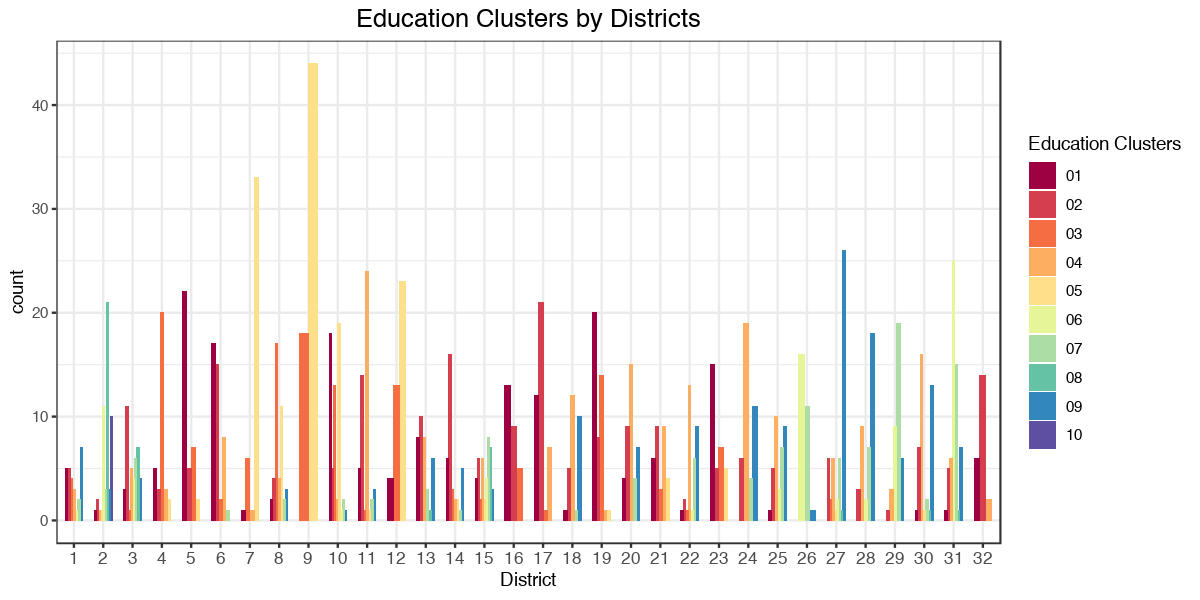

In [149]:
options(repr.plot.width=10,repr.plot.height=5)
p1

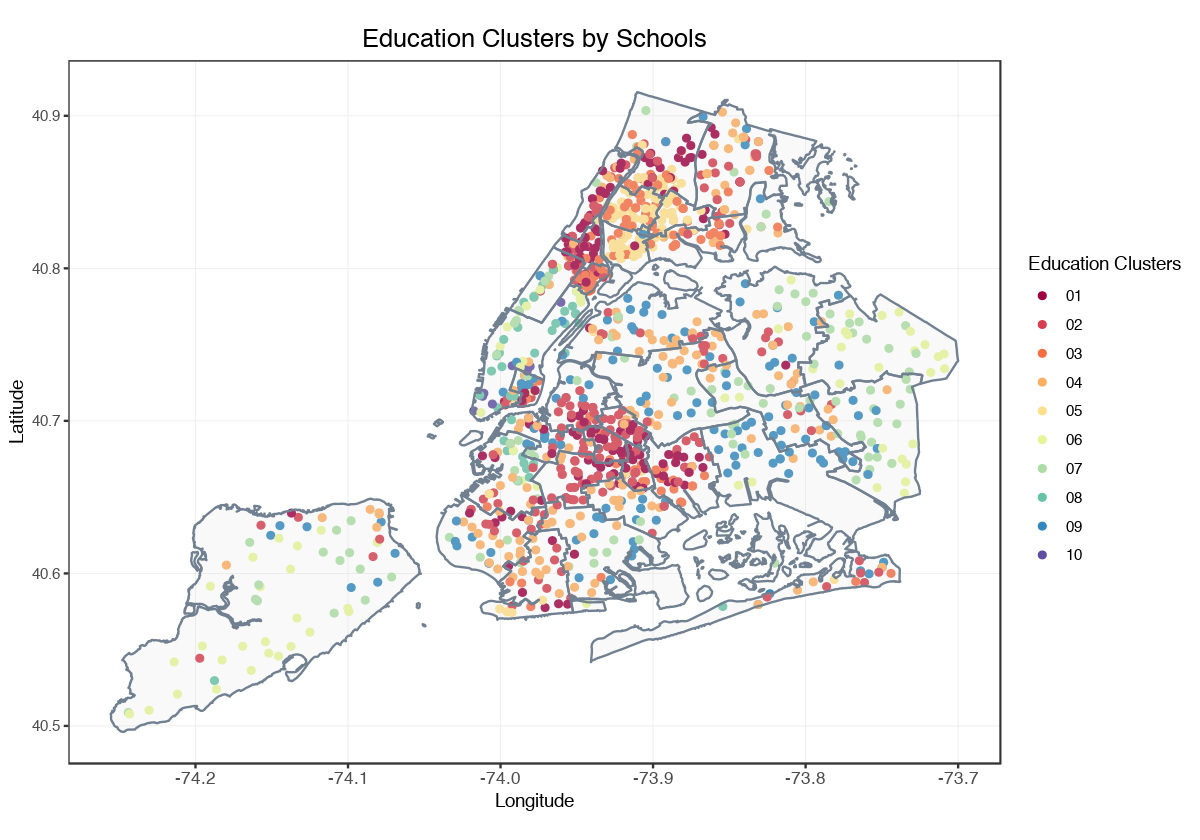

In [150]:
options(repr.plot.width=10,repr.plot.height=7)
p2

Now we can check whether the multidimensional data form a certain structure or don't. 

For this purpose, a probability algorithm and a transformation to two-dimensional space were used. 

The color on the chart still marks educational clusters.

In [1214]:
tsne <- Rtsne(school_explorer[,c(target_list,numeric_list,category_list)],
              dims=2,perplexity=50,verbose=TRUE,max_iter=500)

data_tsne <- data.frame(tsne$Y)
data_tsne$cluster <- school_explorer$Education.Clusters

Read the 1272 x 50 data matrix successfully!
Using no_dims = 2, perplexity = 50.000000, and theta = 0.500000
Computing input similarities...
Normalizing input...
Building tree...
 - point 0 of 1272
Done in 0.27 seconds (sparsity = 0.132805)!
Learning embedding...
Iteration 50: error is 54.109246 (50 iterations in 0.64 seconds)
Iteration 100: error is 47.032181 (50 iterations in 0.69 seconds)
Iteration 150: error is 45.684701 (50 iterations in 0.69 seconds)
Iteration 200: error is 45.182542 (50 iterations in 0.71 seconds)
Iteration 250: error is 44.963899 (50 iterations in 0.76 seconds)
Iteration 300: error is 0.423779 (50 iterations in 0.77 seconds)
Iteration 350: error is 0.268897 (50 iterations in 0.76 seconds)
Iteration 400: error is 0.217810 (50 iterations in 0.72 seconds)
Iteration 450: error is 0.201700 (50 iterations in 0.71 seconds)
Iteration 500: error is 0.190832 (50 iterations in 0.71 seconds)
Fitting performed in 7.15 seconds.


In [1215]:
head(data_tsne)

X1,X2,cluster
-19.196658,-8.074387,01
21.686665,4.788322,10
-1.047503,19.536168,02
-19.750256,-7.642121,01
4.868721,15.640421,06
-8.586061,7.955819,02


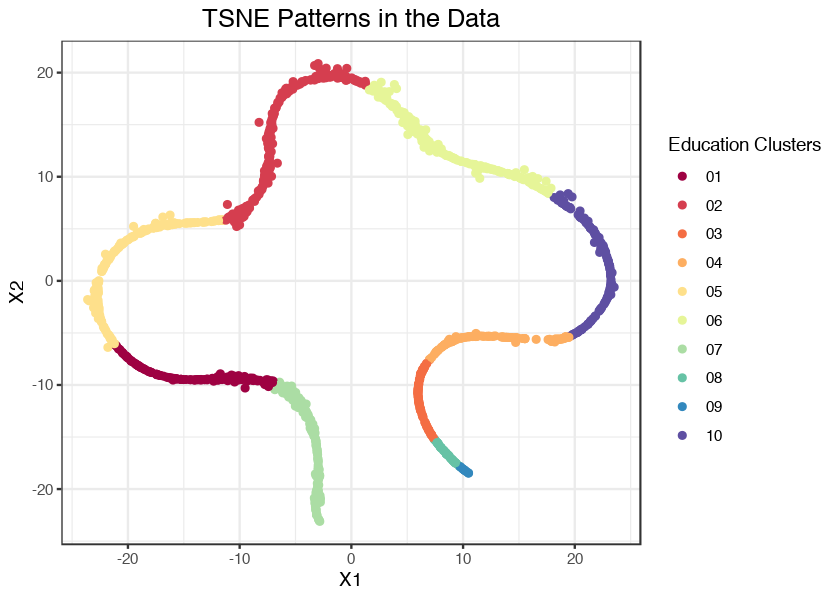

In [1216]:
options(repr.plot.width=7,repr.plot.height=5)
ggplot(data=data_tsne, aes(x=X1,y=X2,color=cluster)) + 
    theme_bw() + geom_point() +
    scale_color_brewer(name="Education Clusters",palette="Spectral") +
    ggtitle("TSNE Patterns in the Data") +
    theme(plot.title=element_text(size=15,hjust=0.5))

It seems like this clustering is done correctly.

## &#x1F310; &nbsp; Feature Correlation

Many numeric variables demonstrate a strong correlation.

Correlation Matrix

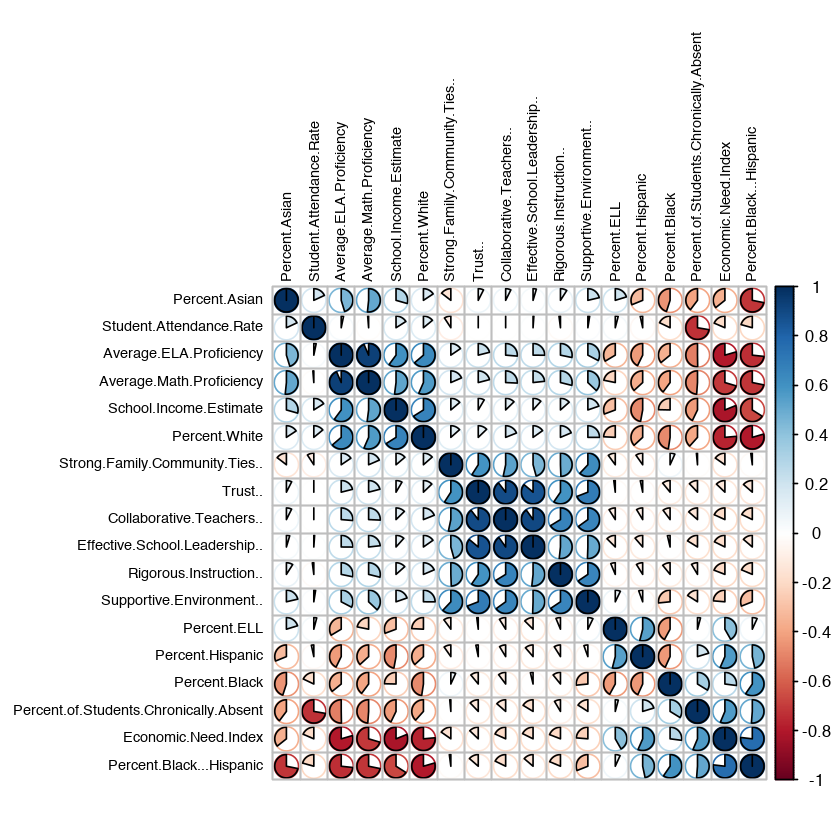

In [1250]:
display_html('<p style="color:#3636ff; font-family:Roboto; font-size:150%; text-shadow:5px 5px 5px #aaa;">
Correlation Matrix</p>')
corr_matrix <- cor(school_explorer[,c(target_list,numeric_list[1:16])], 
                   use="complete.obs",method="pearson")
options(repr.plot.width=7,repr.plot.height=7)
corrplot(corr_matrix,method="pie",order="hclust",
         tl.col="black",tl.cex=0.7)

Education results (ELA & Math) are correlated really strongly so they can be combined into one indicator.

In [1281]:
corr_matrix <- cor(school_explorer[,c(target_list,numeric_list,category_list)], 
                   use="complete.obs",method="pearson")

corr_ela <- corr_matrix[,1]
corr_ela <- data.frame(corr_ela[order(-abs(corr_ela))][2:21])

corr_math <- corr_matrix[,2]
corr_math <- data.frame(corr_math[order(-abs(corr_math))][2:21])

In [1282]:
formattable(corr_ela)

,corr_ela.order..abs.corr_ela....2.21.
Average.Math.Proficiency,0.9352526
Economic.Need.Index,-0.7948646
Percent.Black...Hispanic,-0.7327818
Percent.White,0.6373410
School.Income.Estimate,0.6014640
Grade.5.ELA.4s...All.Students,0.5744089
Grade.4.ELA.4s...All.Students,0.5428655
Grade.5.Math.4s...All.Students,0.5404693
Grade.3.ELA.4s...All.Students,0.5344980
Grade.4.Math.4s...All.Students,0.5140230


In [1283]:
formattable(corr_math) 

,corr_math.order..abs.corr_math....2.21.
Average.ELA.Proficiency,0.9352526
Percent.Black...Hispanic,-0.7181555
Economic.Need.Index,-0.7042218
Grade.5.Math.4s...All.Students,0.6251051
Grade.3.Math.4s...All.Students,0.6237294
Grade.4.Math.4s...All.Students,0.6179292
Grade.5.ELA.4s...All.Students,0.6086593
Grade.4.ELA.4s...All.Students,0.5996167
Grade.3.ELA.4s...All.Students,0.5768744
Percent.White,0.5656733
